<a href="https://colab.research.google.com/github/mpedraza98/MLTSA22_MPedraza/blob/main/HW8/MP_HW8_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib --upgrade

     |████████████████████████████████| 11.2 MB 7.3 MB/s 
     |████████████████████████████████| 900 kB 55.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install george

In [ ]:
import pandas as pd
import numpy as np
import pylab as pl
from scipy import stats
import scipy.optimize as op
from scipy.optimize import minimize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import george
from george import kernels
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/MLTSA22/

/content/gdrive/MyDrive/MLTSA22


Reading in the data. This is the same procedure as we followed for last homework including the data normalization

In [ ]:
lcvs = pd.read_csv('training_set.csv')

In [ ]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [ ]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [ ]:
metadata = pd.read_csv("training_set_metadata.csv")
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [ ]:
# Dictionary that contains the name of each band according to the data_note in kaggle
bands_names = {0:'u', 1:'g', 2:'r', 3:'i', 4:'z', 5:'y'}
bandas = np.sort(lcvs.passband.unique())

In [ ]:
lcvs.shape

(1421705, 6)

In [ ]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


We will shift the time axis for each timeseries. To do this, we will cimply substract the min time value from each point.

In [ ]:
mins = lcvs.groupby(['object_id','passband'])['mjd'].min()
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()
stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std()
means_err = lcvs.groupby(["object_id", "passband"])[["flux_err"]].mean()
stds_err = lcvs.groupby(["object_id", "passband"])[["flux_err"]].std()

In [ ]:
lcvs['s_mjd'] = 0

In [ ]:
lcvs["fluxnormed"] = 0.
lcvs["fluxnormed_err"] = 0.

In [ ]:
def momentos(x, m):
  '''
  Returns the m-th moment of the data
  Receives an array and the moment desired as arguments
  '''
  return stats.moment(x, moment = m)

In [ ]:
def shift_org(df):
  obj, band = df.object_id.values[0], df.passband.values[0]
  df["s_mjd"] = (df["mjd"] - mins.loc[obj, band])
  return df

In [ ]:
def normed(df):
  obj, band = df.object_id.values[0], df.passband.values[0]
  df["fluxnormed"] = (df["flux"] - means.loc[obj, band].values[0]) / stds.loc[obj, band].values[0]
  df["fluxnormed_err"] = (df["flux_err"] - means_err.loc[obj, band].values[0]) / stds_err.loc[obj, band].values[0]
  return df

In [ ]:
lcvs = lcvs.groupby(["object_id", "passband"]).apply(shift_org)

In [ ]:
lcvs = lcvs.groupby(["object_id", "passband"]).apply(normed)

In [ ]:
max_timeseries = lcvs.groupby(['object_id','passband'])[['s_mjd']].max().reset_index()
max_timeseries.rename(columns = {'s_mjd' : 'max_time'}, inplace = True)

In [ ]:
max_timeseries.head()

,object_id,passband,max_time
0,615,0,797.8763
1,615,1,873.7530
2,615,2,873.7531
3,615,3,873.7530
4,615,4,873.7572


In [ ]:
max_timeseries.shape

(47088, 3)

In [ ]:
max_timeseries[max_timeseries.passband == 0].describe()

,object_id,passband,max_time
count,7.848000e+03,7848.0,7848.000000
mean,4.810375e+07,0.0,864.051928
std,4.347364e+07,0.0,133.695239
min,6.150000e+02,0.0,355.921800
25%,3.180865e+05,0.0,794.791900
50%,4.131719e+07,0.0,829.790200
75%,8.665901e+07,0.0,951.903625
max,1.307798e+08,0.0,1091.773900


In [ ]:
max_timeseries[(max_timeseries.max_time <= 1000) & (max_timeseries.max_time >= 550)].shape

(36659, 3)

We're interested in looking at the distribution of the maximum value of the timestams. Since we want to create an evenly sampled timeseries, we need to choose an appropiate upper limit, so that we do not left out a significant part of the original data, or we have to interpolate to get too many points after the original range.

<AxesSubplot:>

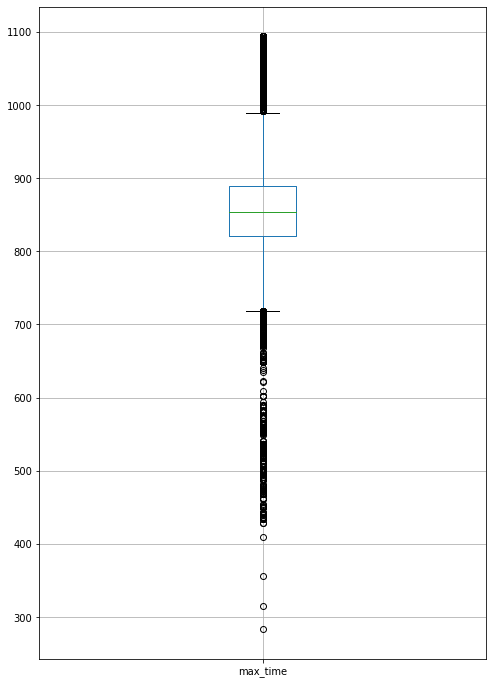

In [ ]:
max_timeseries.boxplot(column = ['max_time'], figsize = (8, 12))

**Fig 1** Box and whiskers plot for the maxium timestamp of the timeseries. For almost 75% of all the timeseries, the max timestamp is 900. Therefore, this will be the value we will choose as the upper limit for the dataset with evenly spaced data.

It is worth noticing that there is a great number of outliers under the minimum of the box. This is going to lead to interpolate many time series beyond their original range where we have no information of their behavior.

<font color="red"> FBB ok</font>

<AxesSubplot:title={'center':'max_time'}, xlabel='passband'>

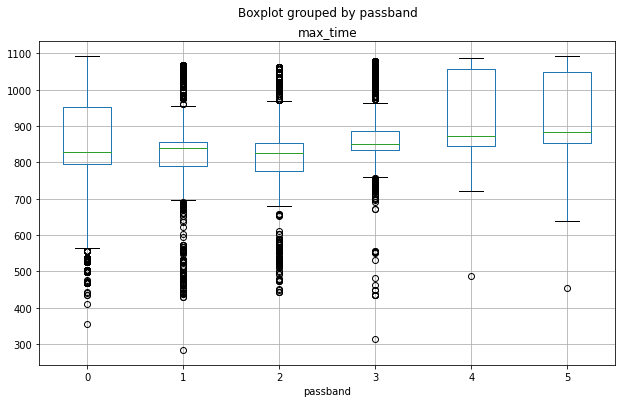

In [ ]:
max_timeseries.boxplot(column = ['max_time'], by = 'passband', figsize = (10, 6))

**Fig 2** Box and whiskers plot for the maximum flux value of each band. The discrimination for each band provides information about which of them will be more affected by possible non accurate interpolations.

<font color="red"> FBB nice</font>

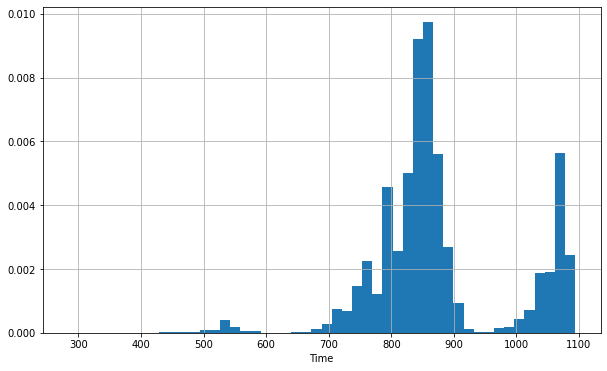

In [ ]:
max_timeseries['max_time'].hist(density = True, bins = 50, figsize = (10,6));
pl.xlabel('Time');

**Fig 3** Distribution of the maximum timestamp for all timeseries. This plot suggests that most of the data has an upper limit between 800 and 900. Therefore, our choice of 900 as the upperlimit for the new timeseries seems appropiate.

<font color="red"> FBB nice!</font>

In [ ]:
#count_timeseries = lcvs.groupby(['object_id','passband'])[['mjd']].count().reset_index()
#count_timeseries.rename(columns = {'mjd' : 'cuenta'}, inplace = True)

In [ ]:
#count_timeseries.boxplot(column = ['cuenta'], figsize = (10, 6))

In [ ]:
N_samples = 100
upper_limit = 900

In [ ]:
t = np.linspace(0, 900, N_samples)

In [ ]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    ll = gp.lnlikelihood(y, quiet = True)

    # We took this line of code from the documentation to deal with the error
    # of a matrix non positive definite, that arises for some timeseries
    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet = True)

In [ ]:
temp = lcvs[(lcvs.object_id==615) & (lcvs.passband == bandas[0])]

In [ ]:
y = temp.fluxnormed.values

In [ ]:
kernel = np.var(y) * kernels.Product(kernels.ExpSquaredKernel(1.4), kernels.CosineKernel(2))
gp = george.GP(kernel)
gp.compute(temp.s_mjd.values, temp.fluxnormed_err.values)

#Optimize the parameters
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
gp.set_parameter_vector(result.x)

#pred, pred_var = gp.predict(temp.fluxnormed.values, temp.mjd.values, return_var=True)

In [ ]:
pred, pred_var = gp.predict(temp.fluxnormed.values, temp.s_mjd.values, return_var=True)

In [ ]:
pred1, pred_var1 = gp.predict(temp.fluxnormed.values, t, return_var=True)

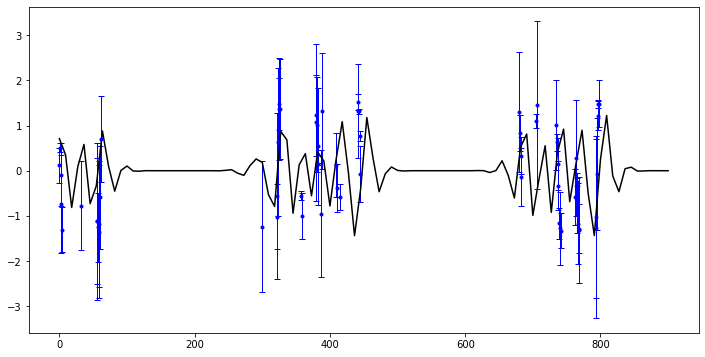

In [ ]:
fig3 = pl.figure(figsize = (12,6))
#pl.plot(temp.s_mjd.values, pred, "k", lw=1.5, alpha=1)
pl.errorbar(temp.s_mjd.values , temp.fluxnormed.values, temp.fluxnormed_err.values, fmt='.', color='b', elinewidth=1, capsize=3)
pl.plot(t, pred1, 'k')

**Fig 4** Example of the gaussian interpolation for object 615. 

We decided to store the data in a numpy array of 47088 rows and 100 columns, i.e, one row per band per object and one column per timestep in every timeseries. This is how the data will be fed to the autoencoder.

<font color="red"> FBB hmmm you had a good model in HW 7, what changed here? what happened??</font>

In [ ]:
shape = lcvs.object_id.unique().shape[0] * lcvs.passband.unique().shape[0]

In [ ]:
data = np.zeros((shape,N_samples))

In [ ]:
for i, j in enumerate(objects):
  print(i)
  for k in range(6):
    temp = lcvs[(lcvs.object_id == j) & (lcvs.passband == k)]
    y = temp.fluxnormed.values

    kernel = np.var(y) * kernels.Product(kernels.ExpSquaredKernel(3), kernels.CosineKernel(1.6))
    gp = george.GP(kernel)
    gp.compute(temp.s_mjd.values, temp.fluxnormed_err.values)

    #Optimize the parameters

    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
    gp.set_parameter_vector(result.x)

    pred, pred_var = gp.predict(temp.fluxnormed.values, t, return_var=True)

    data[6*i+k] = pred
    print(6*i+k)

Output streaming troncato alle ultime 5000 righe.
42802
42803
7134
42804
42805
42806
42807
42808
42809
7135
42810
42811
42812
42813
42814
42815
7136
42816
42817
42818
42819
42820
42821
7137
42822
42823
42824
42825
42826
42827
7138
42828
42829
42830
42831
42832
42833
7139
42834
42835
42836
42837
42838
42839
7140
42840
42841
42842
42843
42844
42845
7141
42846
42847
42848
42849
42850
42851
7142
42852
42853
42854
42855
42856
42857
7143
42858
42859
42860
42861
42862
42863
7144
42864
42865
42866
42867
42868
42869
7145
42870
42871
42872
42873
42874
42875
7146
42876
42877
42878
42879
42880
42881
7147
42882
42883
42884
42885
42886
42887
7148
42888
42889
42890
42891
42892
42893
7149
42894
42895
42896
42897
42898
42899
7150
42900
42901
42902
42903
42904
42905
7151
42906
42907
42908
42909
42910
42911
7152
42912
42913
42914
42915
42916
42917
7153
42918
42919
42920
42921
42922
42923
7154
42924
42925
42926
42927
42928
42929
7155
42930
42931
42932
42933
42934
42935
7156
42936
42937
42938
42939
42940
4

In [ ]:
np.savetxt('data.csv', data, delimiter=',')

In [ ]:
pl.plot(t, data[2002])

NameError: ignored